<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

/tmp/ipykernel_30/1618087579.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


1001 examples in training, 459 examples in testing.
Dropped redundant features (correlation > 0.9): set()
Features with highest correlation (Top 15): Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   MSSubClass     1460 non-null   int64
 1   LotArea        1460 non-null   int64
 2   OverallQual    1460 non-null   int64
 3   OverallCond    1460 non-null   int64
 4   YearBuilt      1460 non-null   int64
 5   YearRemodAdd   1460 non-null   int64
 6   BsmtFinSF1     1460 non-null   int64
 7   BsmtFinSF2     1460 non-null   int64
 8   BsmtUnfSF      1460 non-null   int64
 9   TotalBsmtSF    1460 non

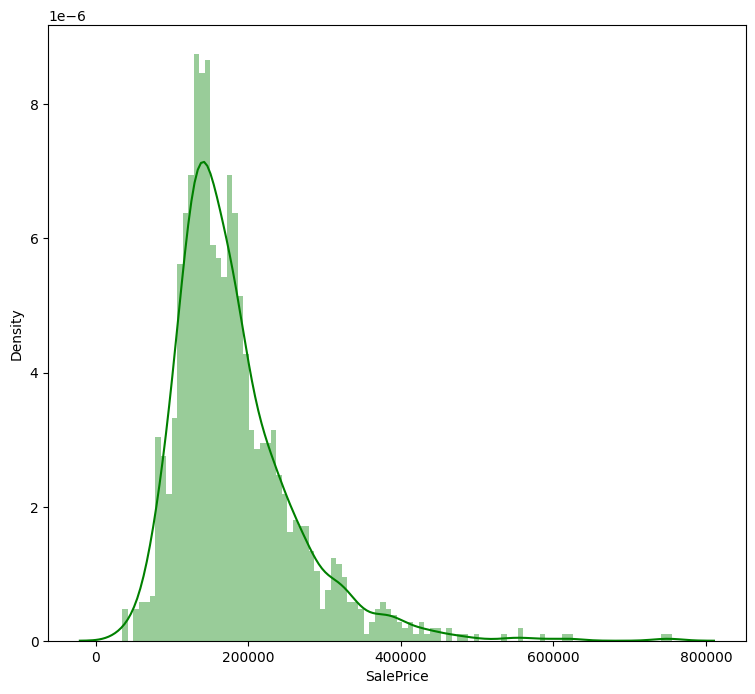

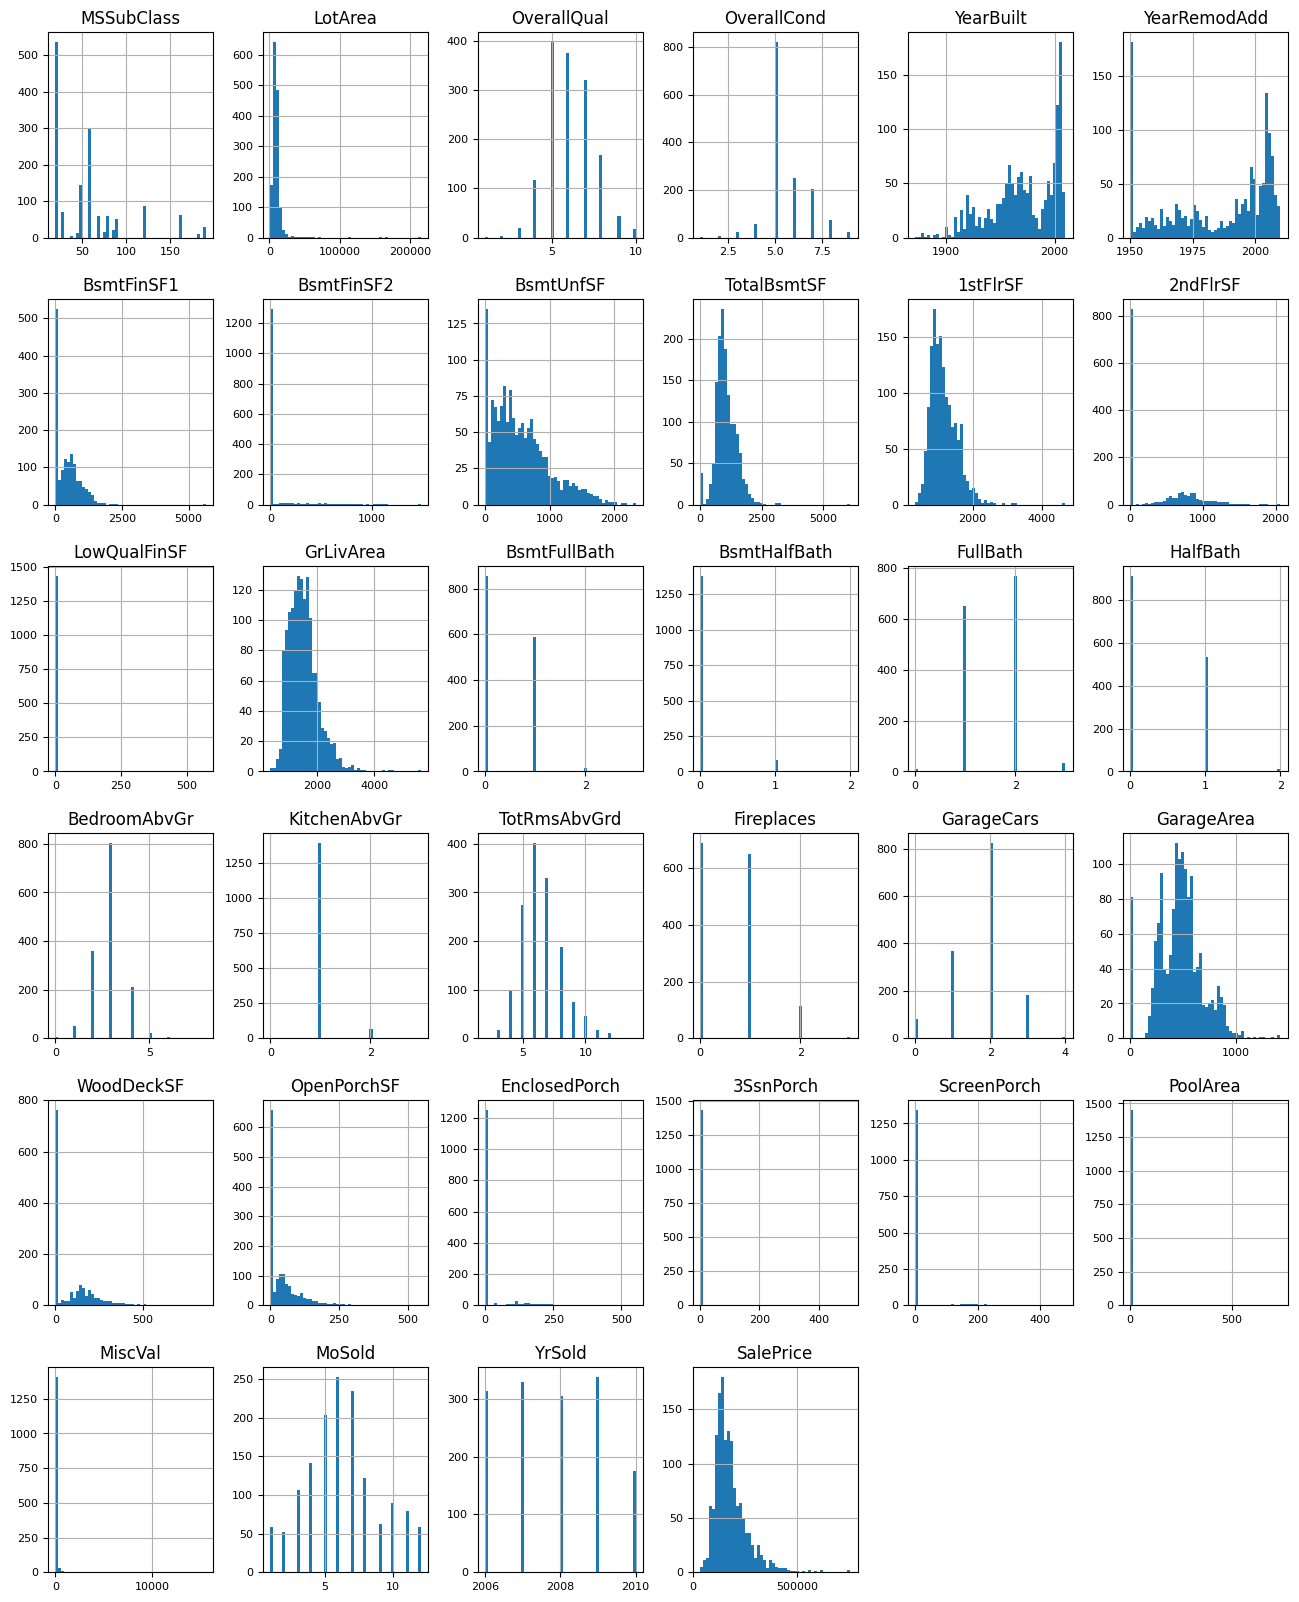

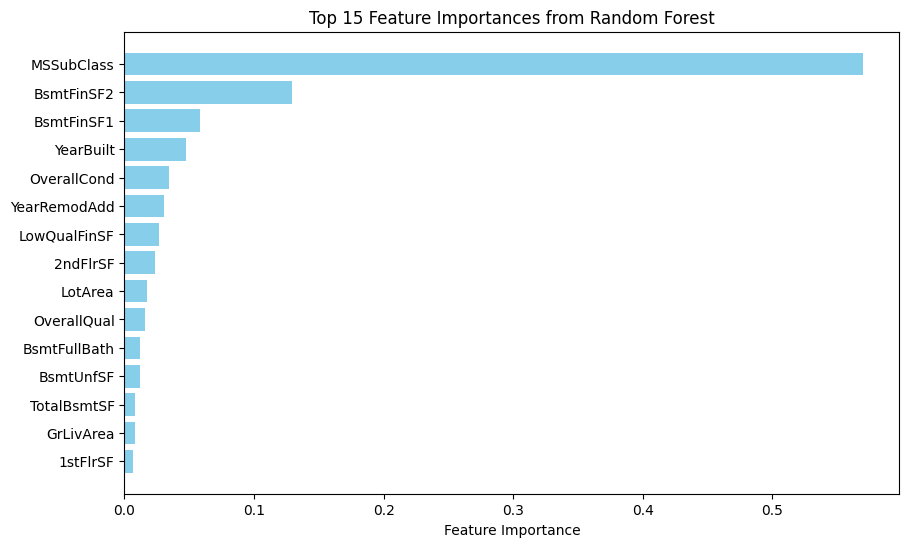

In [7]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor 
dataset_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
dataset_df.head(3)

dataset_df = dataset_df.drop('Id', axis=1)
dataset_df.head(3)

dataset_df.info()



import matplotlib.pyplot as plt
import seaborn as sns
print(dataset_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(dataset_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

list(set(dataset_df.dtypes.tolist()))

df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

#drop null cols
columns_to_drop = df_num.columns[df_num.count() != 1460]

df_num.drop(columns_to_drop, axis=1, inplace=True)
df_num.info()


df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

import numpy as np

###############
def split_dataset(dataset, test_ratio=0.30, random_seed=42):
    # Set the random seed for reproducibility
    np.random.seed(random_seed)
    
    # Generate random indices for the test set based on the test ratio
    test_indices = np.random.rand(len(dataset)) < test_ratio
    
    # Split the dataset into training and testing based on the random indices
    train_ds_pd = dataset[~test_indices]  # Select training set (non-test indices)
    valid_ds_pd = dataset[test_indices]   # Select validation set (test indices)
    
    return train_ds_pd, valid_ds_pd



#non-null features
train_ds_pd_non, valid_ds_pd_non = split_dataset(df_num)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd_non), len(valid_ds_pd_non)))

######################Feature selection#############################
# Prepare data
X = train_ds_pd_non.drop('SalePrice', axis=1)  # Features
y = train_ds_pd_non['SalePrice']  # Target variable


# Drop redundant features based on correlation
# Compute the correlation matrix
correlation_matrix = X.corr().abs()

# Set a threshold for high correlation
threshold = 0.9
to_drop = set()

# Loop over the upper triangle of the correlation matrix
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            to_drop.add(colname)

# Drop the highly correlated features
X = X.drop(to_drop, axis=1)


print(f"Dropped redundant features (correlation > {threshold}): {to_drop}")


# Correlation-Based Feature Selection
# Select features with the highest correlation to the target variable
selector = SelectKBest(f_regression, k=15)  # Choose top 15 features
X_filtered = selector.fit_transform(X, y)
correlation_features = X.columns[selector.get_support(indices=True)]

print("Features with highest correlation (Top 15):", correlation_features)


# Tree-Based Feature Importance
model = RandomForestRegressor()
model.fit(X_filtered, y)


# Get feature importances
importances = model.feature_importances_
feature_names = X.columns
FN = feature_names

df_num = df_num[FN]
df_num.info()

# Sort features by importance
sorted_idx = importances.argsort()[::-1]
sorted_features = feature_names[sorted_idx]
sorted_importances = importances[sorted_idx]

# Print top 15 most important features
print("\nTop 15 most important features by Random Forest:")
for idx, (f, i) in enumerate(zip(sorted_features[:15], sorted_importances[:15]), start=1):
    print(f"{idx} - {f}: {i:.4f}")

plt.figure(figsize=(10, 6))  # Set figure size
plt.barh(sorted_features[:15], sorted_importances[:15], color='skyblue')  # Create horizontal bar chart
plt.xlabel('Feature Importance')  # Label for the x-axis
plt.title('Top 15 Feature Importances from Random Forest')  # Chart title
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()  # Display the plot




####################################################
import pandas as pd 
from sklearn.feature_selection import SelectKBest, f_regression 
from sklearn.ensemble import RandomForestRegressor  
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 






In [10]:
# Train the Random Forest model
model = RandomForestRegressor(random_state=42) 
model.fit(X_filtered, y) 


test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
# create a csv that contains the predicted SalePrice for each observation in the test.csv dataset.
test.info()
test = test[correlation_features]
test.head(3)


test.fillna(test.mean(), inplace=True)
test.info()


# Evaluate the model
X_valid = valid_ds_pd_non.drop('SalePrice', axis=1).drop(to_drop, axis=1)
X_valid_filtered = selector.transform(X_valid)
y_valid = valid_ds_pd_non['SalePrice']
y_pred = model.predict(X_valid_filtered)
mse = mean_squared_error(y_valid, y_pred)
print(f"Mean Squared Error on validation set: {mse:.2f}")


# Preprocess the new data 
test_filtered = test[correlation_features]  

# Make predictions
new_predictions = model.predict(test_filtered)

# Print the predictions
print("",new_predictions)

predicted_df = pd.DataFrame({'SalePrice': new_predictions})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
